## Main Imports

In [26]:
import os
import pandas as pd
import datetime
import time
import json # Export dictionary of tuned parameters.
from sklearn.model_selection import train_test_split, TunedThresholdClassifierCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning.
from sklearn.metrics import classification_report



# Evaluation metrics import
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, 
    confusion_matrix
)

# Models import
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Visualisations import
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#This is for data, which is most important split.
RANDOM_STATE = 42

## Functions Setup for the models

In [3]:
# Load Data
def load_data(file_path):
    return pd.read_csv(file_path, compression='gzip')

# Train Data
def train_data(data, model, label_col, test_size=0.2, random_state=42, standardize=True, with_pca=False, n_pca_components=10):
    """
    Preprocess data and gives back fitted model. Includes different options mainly related to standardization of features and use of PCA.
     
    Parameters
    ----------
    model: {sklearn object} Non fitted model object from sklearn. Should be tuned already.
        
    TO DO
    
    
    Returns
    -------
    TO DO    
        
        
    """
    # Split the dataset into features and labels
    X = data.drop(columns=[label_col]).values
    y = LabelEncoder().fit_transform(data[label_col].values)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Standardize features (fit on training set, transform both train and test if necessary)
    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Apply PCA (fit on training set, transform both train and test if necessary)
    if with_pca:
        pca = PCA(n_components=n_pca_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test) 

    # Train the model
    print(f"Training {model.__class__.__name__}...")
    model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test


# Evaluate Model
def evaluate(model, X_test, y_test):
    """
    Takes in any fitted model and gives all the metrics that are asked
    Should be used for the results of the hypertuned model.

    Parameters
    ----------
    model: {sklearn object} Fitted model from sklearn. 
    
    X_test: {array like n*p} Features of test set/left out sample.

    y_test: {array like n*1} Feature that is being predicted. 

    
    Returns
    -------

    results_df: {pandas df} Contains all metrics

    confusion: Elements to plot confusion matrix.
    
    
    
    """
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    confusion = confusion_matrix(y_test, y_pred)

    # Prepare metrics for DataFrame
    results = {
        "Metric": ["Accuracy", "Balanced Accuracy", "F1 Score", "AUC"],
        "Value": [accuracy, balanced_accuracy, f1, auc_score]
    }
    results_df = pd.DataFrame(results)
    return results_df, confusion

def cross_validate(model,X_train,y_train):
    """
    Check how to build the hyperparameter tuning, working below.
    Employ cross validation AND Hypertune to maximize F1 score, that way we kill 2 birds in one stone.
    """

    # Should return the optimal attributes for t
    pass


## Visualizations related functions

In [15]:
def plot_confusion_matrix(confusion, labels, title="Confusion Matrix"):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

## Workflow with a loop (Looping through the classifiers)

### Classifiers (with standardize parameter)

This dictionary here can be modified. Within each model we add the tuning parameters from the cross validation.
But then we don't have to change anything else.

In [16]:
classifiers = {
    "LDA": {
        "model": LinearDiscriminantAnalysis(),
        "standardize": True
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "standardize": True
    },
    "QDA": {
        "model": QuadraticDiscriminantAnalysis(),
        "standardize": True
    },
    "k-NN": {
        "model": KNeighborsClassifier(n_neighbors=5),
        "standardize": True
    },
    "GBDT": {
        "model": GradientBoostingClassifier(),
        "standardize": False
    },
    "Random Forest": {
        "model": RandomForestClassifier(n_estimators=100, random_state=42),
        "standardize": False
    },
    "SVM": {
        "model": SVC(probability=True),
        "standardize": True
    }
}

### Loading the data from the path

In [4]:
file_path = "Datasets/data1.csv.gz" 
label_column = "label" 

# Load the dataset
data = load_data(file_path)

### Printing all the results

In [52]:
results_df.loc[results_df["With PCA"]==False, :]

,Model,With PCA,Accuracy,Balanced Accuracy,F1 Score,AUC
0,LDA,False,0.700457,0.700674,0.632287,0.738854
2,Logistic Regression,False,0.953425,0.950146,0.936646,0.991995
4,QDA,False,0.528767,0.539963,0.475610,0.539963
6,k-NN,False,0.729680,0.666834,0.538941,0.714191
8,GBDT,False,0.948858,0.937660,0.927835,0.989834
10,Random Forest,False,0.941553,0.923532,0.914894,0.989892
12,SVM,False,0.964384,0.953582,0.949547,0.992598


In [53]:
results_df.loc[results_df["With PCA"]==True, :]

,Model,With PCA,Accuracy,Balanced Accuracy,F1 Score,AUC
1,LDA,True,0.943379,0.924452,0.917112,0.989838
3,Logistic Regression,True,0.960731,0.954874,0.945776,0.991586
5,QDA,True,0.953425,0.945446,0.935197,0.989680
7,k-NN,True,0.931507,0.914551,0.901186,0.971316
9,GBDT,True,0.937900,0.926913,0.912821,0.984396
11,Random Forest,True,0.944292,0.933530,0.921694,0.981991
13,SVM,True,0.960731,0.952785,0.945223,0.992376


# Hyper parameter tuning. 
Tune the hyper parameters with the goal of improving the <b>F1 score</b>. 

Tough to completely merge with other part of the code. Ideally we get the results in a dict and then don't have to rerun that code ever again.

A search consists of:
an estimator (regressor or classifier such as sklearn.svm.SVC()) <b>All our estimators are here, 7*2 for PCA</b>

a parameter space <b>This is a bit of guess work</b>

a method for searching or sampling candidates <b>Grid search CV</b>

a cross-validation scheme; <b>5-fold</b>

a score function.<b>F1 score</b>



## Ideally save grid search results to a json file and then return to dict.

- Unpack the dictionary into the model!! ** super easy!
- Take care of the fixed params as well! Most of them have default values but logit for example has some fixed params which are not default, these are not saved. 


## Preprocessing before each fit: using a pipeline!

https://stackoverflow.com/questions/55692298/preprocessing-on-gridsearchcv

https://www.youtube.com/watch?v=tIO8zPCdi58

## What happens if a model from the cv takes too long?
Break the model or what? Set limit to iter?

- Gridsearch is pretty strong so even if inner model raises error it will not terminate, which is nice!

## Some paremeters need specific solver:
- Solution is to give 2 dictionaries, so GridSearch will search over 2 grids. LDA will give an example.
    https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search

## Controlling randomness -> The instructions want reproducibility.
https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness
- Recommendation is to set seed for every random estimator!!! Oh jesus.
- Most of our estimators are non random (at least in theory).
- What is clearly random is our CV in grid search.
- Should fix the randomness of our estimators at least for the  

In [8]:
def train_split(data,label_col,random_state,test_size=0.2):
    """
    Needs to be like this now as we can't preprocess the train data as we will run cross validation on it, therefore we need to preprocess
    on each split.

    """
    X = data.drop(columns=[label_col]).values
    y = LabelEncoder().fit_transform(data[label_col].values)
    
        # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, y_train, X_test, y_test

In [13]:
X_TRAIN_G, y_TRAIN_G, X_TEST_G ,y_TEST_G  = train_split(data,label_col="label",random_state=RANDOM_STATE,test_size=0.2)

In [16]:
print(X_TRAIN_G.shape, y_TRAIN_G.shape, X_TEST_G.shape, y_TEST_G.shape)

(4376, 4123) (4376,) (1095, 4123) (1095,)


In [12]:
X_TRAIN_G.shape

(1095, 4123)

In [74]:
def pipe_maker(model_name, model,standardize=False,with_pca=False, n_pca_components=10):
    """
    Makes different pipelines according to learning model and standarization/pca requirements

    """

    set_instructions = []
    if standardize:
        scaler = StandardScaler()
        set_instructions.append(("scaler",scaler))
    
    # Apply PCA (fit on training set, transform both train and test if necessary)
    if with_pca:
        pca = PCA(n_components=n_pca_components)
        set_instructions.append(("pca",pca))
    set_instructions.append((model_name,model))    

    pipe = Pipeline(set_instructions)

    return pipe

In [8]:
# The way the file is defined it will not overwrite, which is good, but should be taken into account.
def hyper_param(path=".json",params={}):
    with open(path, "w") as outfile: 
        json.dump(params, outfile)
        outfile.close()
        

## Tuning params table:

- The fixed params and grid search params all follow the "model_name"__"param to modify" convention, it could be automated
but I think it is not needed. TO BE DISCUSSED.
- If we have time I would like to run some basic data analysis on the cross fiting results, not just keeping the maximum.
- Even if results are same as unparametrized, I am using less data to estimate the model so hopefully when we do the final fit, and check on the test set the results should improve.

| Model | PCA | Standardization | Tuning params | Explanation | Preliminary F1       |   TIME |
|----------------|--------------|------------|---|----|-----|--------|
| Linear discriminant analysis  |  NO     | YES  |solver, shrinkage| Big covariance matrix reguralizing it will make it easier to estimate. <br /> Use the other solver because it supports shrinkage, svd just to compare to baseline we ran |    0.93 <b>Very nice now:)</b> | 15 min
|Logistic regression |  NO | YES | C, l_ratio, class_weight| Mostly just use shrinkage, elastic nest nesting lasso and ridge, different regularisation strengths. Most interesting is class weights, have some balance.   |  0.94   | 87 min, no convergence |
|QDA|NO|YES|some regularisation that is not working|| garbage|4 min|
|K-nn|NO|YES|n_neighbors,metric,p,weights,n_jobs|Number of neigh is self explanatory, for distance minkowski is default but nests euclidenan and manhattan, testing a few distances nested in Minkowski. Weights is for decision rule of voting, closest in neighborhood have more weight or uniform|1000min |0.74 good improvement, room for more.|
|SVM|NO|YES|C,kernel,gamma,class_weight|Kernels are the most interesting thing to tune, gamma is hyper param of some kernels, C is the regularisation that was important in some models, class weight I still don't know why I touch that|0.94 similar to unoptimized |129 min| 
|Random Forest|NO|NO|n_trees,criterion,max_features|Number of trees is key, up to 300, if it doesn't take an eternity I can go to 500. Criterion just because we showed in class. Features because it is interesting to see (log2 harsher). Finally no pruning, would take an eternity and random forest supposedly doesn't need it. Boot and max features should take care of overfitting.|0.91 same as unparametrized.|3 minutes, so room for more tuning then|
|Gradient Boosted| NO  | NO |loss, learning_rate, max_depth, max_features, n_iter_no_change, n_estimators | Ok, I do not fully know what I am doing with this one. Learning rate is v from the book I think, it is a regularisation parameter. n estimators is the number of steps M, there is a tradeoff between M and v. Max depth is J from the book I think. Features introduces some random forest component to this algorithm. Finally early stopping to 15 because I am impatient.|0.938 small improvement but ok. |   87min |

In [166]:
# empty_dict ={"key":{"hey":"2"}}
# if hasattr(empty_dict,"key"):
#     print("yes")

In [175]:
tuning_lda = {
    "lda": {
        # IF PCA TRUE THE NAME SHOULD BE lda_pca
        "model": LinearDiscriminantAnalysis(),
        "preprocess": {
            "standardize":True,
            "pca":False
        },
        "fixed_params" : {
            #No default parameters, but doing so would raise error, add fake one
            "lda__tol":0.0001
            },
        # Two grids, one of the solvers does not support shrinkage
        "grid_search_params":[
            {
            "lda__solver":["svd"]
        },
            {
            "lda__solver":["lsqr"],
            "lda__shrinkage":[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, "auto"]   
        }
                             ]
    
    
    }

}

In [180]:
[i/10  for i in range(11)]

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [188]:
# MODELS SHOULD BE NAMED model model_pca
# Seems like it plateaus at 0.94
tuning_logit = {
    "logit": {
        "model": LogisticRegression(),
        "preprocess": {
            "standardize":True,
            "pca":False
        },
        "fixed_params" : {
            "logit__max_iter":100,
            "logit__solver":"saga", # Class weight can be an interesting parameter to check.
            "logit__n_jobs":-1, # How does paralelizing the logit work??????
            "logit__penalty":"elasticnet", 
                        }
        ,
        "grid_search_params":{
            # Lower C is higher penalty, if optimal is not at bound the approximation is good enough
            "logit__C":[0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001,5,10],
            "logit__l1_ratio":[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # Nests lasso and ridge both edges.
            "logit__class_weight":[None,"balanced"] # Uses inverse probability weighting. I really don't like this
            # Class is not that unbalanced but try it.
            
        }
    }
    
}
 

In [192]:
tuning_qda = {
    "qda": {
        "model": QuadraticDiscriminantAnalysis(),
        "preprocess": {
            "standardize":True,
            "pca":False
        },
        "fixed_params" : {
            "qda__priors":None
                        }
        ,
        "grid_search_params":{
            # Lower C is higher penalty, if optimal is not at bound the approximation is good enough
            "qda__reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            
            
        }
    }
    
}

In [198]:
[i for i in range(1,21,2)]

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

In [203]:
tuning_knn = {
    "knn": {
        "model": KNeighborsClassifier(),
        "preprocess": {
            "standardize":True,
            "pca":False
        },
        "fixed_params" : {
            "knn__metric":'minkowski',
            "knn__n_jobs":1 # Just paralelize the cv not the model itlself.
                        }
        ,
        "grid_search_params":{
            # This will have to be reduced it takes way too long!
            # From 0 to 1 these are not distances, so be careful or make the test params sparser from 0 to 1
            "knn__p": [0.8, 1.0, 1.2,  1.4,  1.7, 2.0, 2.2, 3.0, 10.0],#Del 0 al 2 y 3,4,10
            "knn__weights":['uniform','distance'],
            # If best near the edge we can fine tune there.
            "knn__n_neighbors": [1 , 3, 5, 9, 11, 15, 20, 30]

            
            
        }
    }
    
}

In [5]:
tuning_svm = { 
    "svm": {
        "model": SVC(),
        "preprocess": {
            "standardize":True,
            "pca":False
        },
        "fixed_params" : {
            "svm__degree":3                        
        }
        ,
        "grid_search_params":{
            # Same as in logit, if near edges we can modify it.
            "svm__C": [0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801, 0.901, 1.001,5,10] ,
            # Kernel is the most fun thing.
            "svm__kernel":["linear","poly","rbf","sigmoid"],
            # If best near the edge we can fine tune there.
            "svm__gamma": ["scale","auto"],
            "svm__class_weight": [None,"balanced"]

            #Will need to fix the random state of the model.
            
        }
    }
    
}

In [16]:
tuning_rf = { 
    "rf": {
        "model": RandomForestClassifier(),
        "preprocess": {
            "standardize":False,
            "pca":False
        },
        "fixed_params" : {
            # Almost in the definition of a random forest.
            "rf__bootstrap":True                        
        }
        ,
        "grid_search_params":{
            # If expensive kick out the highest number of trees.
            # 100 is default
            #Not playing with tree depth or whatever, trees are going to go deep.
            "rf__n_estimators": [100,200,300,400] ,
            "rf__criterion":["gini","entropy"],
            "rf__max_features":["sqrt","log2"] # log2 is more strict!
            

            #Will need to fix the random state of the model.
            
        }
    }
    
}

In [46]:
tuning_gbdt = { 
    # This is not working too well I feel like but whatever.
    "gbdt": {
        "model": GradientBoostingClassifier(),
        "preprocess": {
            "standardize":False,
            "pca":False
        },
        "fixed_params" : {
            # Almost in the definition of a random forest.
            "gbdt__loss":"log_loss",
            "gbdt__n_iter_no_change":15 # Early stopping I don't want to spend eternity.
        }
        ,
        "grid_search_params":{
            # If expensive kick out the highest number of trees.
            # 100 is default
            #Not playing with tree depth or whatever, trees are going to go deep.
            "gbdt__n_estimators": [100,200,300,400,500],#[100,200], # I think in this context this is M from the book.
            "gbdt__max_depth":[1,3,5,7,9],#[1,3,5], # I think this is J from the book.
            "gbdt__learning_rate":[0.1,0.05,0.2,0.3],#[0.05, 0.1, 0.2], # This is v in the book I think, tradeoff between M and v
            # I think we want small v, depends on iterations and max depth of the tree.
            "gbdt__max_features":["sqrt",100,130] # This param with None makes it 5 minutes per iter.
            #[None,"log2"] # Default is None, but why not introduce a random forest component.
            # subsample could also be interesting to tune.
            
            #This a bit useless probably, as the model with None was so powerful already. -> OH BASELINE 93.5 ok we can work with that.
            #Will need to fix the random state of the model.
            
        }
    }
    
}

# 1.3 3 ideas:
https://scikit-learn.org/stable/modules/ensemble.html# Ensembles are usually super powerful.
- Adaboost in action use decision tree as base learner. We can also tune the base learner, try and iteratively fit SVC or something along those lines.
- Random forests or gbdt can be very tuned and should yield some good estimates.
- Use PCA somehow, test different optimal number of components.
- t-SNE or UMAP, modern dimensionality reduction algorithms.

https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py
If we can reduce dimensionality to 2 we can plot these decision boundary plots that are so cute.


| Model | PCA | Standardization | Tuning params | Explanation | Preliminary F1       |   TIME |
|----------------|--------------|------------|---|----|-----|--------|
| ADABOOST  |  YES     | YES  |estimator, n_estimators, learning_rate| We can try to play with the baseline estimators of the adaboost algorithm. We can sue an SVC or something like that. Try the baseline to be the trees and svc. Then we can modify the number of iterations as well as the learning rate which would be the alpha params. It may be good to keep it low as high values may lead to overfitting. SEEMS LOGISTIC AS BASELINE CAN BE GOOD| 0.93 | 10 min
| Try ThresholdClassifierCV()  |       |   | || 
| PCA toy around justified by screeplot.  |       |   | || 

## 1.3 Approach 1

In [111]:
#{'ada_boost__estimator': LogisticRegression(), 'ada_boost__learning_rate': 0.5, 'ada_boost__n_estimators': 200, 'pca__n_components': 50}
# 0.946
tuning_ada_boost = { 
    # This is not working too well I feel like but whatever.
    # The JSON will give an error which is problematic. because decision tree classifier
    # gets returned.
    "ada_boost": {
        "model": AdaBoostClassifier(),
        "preprocess": {
            "standardize":True, # Needed for the SVC.
            "pca":True
        },
        "fixed_params" : {
            # Almost in the definition of a random forest.
            "ada_boost__algorithm":"SAMME"
        }
        ,
        "grid_search_params":{
            # If expensive kick out the highest number of trees.
            # 100 is default
            #Not playing with tree depth or whatever, trees are going to go deep.
            "ada_boost__estimator": [DecisionTreeClassifier(max_depth=2),LogisticRegression()], # Try good model as base, may overfit.
            "ada_boost__n_estimators":[50,100,200,300,400], # Keep iterations low for complex model
            "ada_boost__learning_rate":[0.05,0.1,0.2,0.5,0.6, 1,1.5], # This would be alpha or similar, keep low so as not to ofit.
            "pca__n_components":[8,10,12,15,25]
        }
    }
    
}

## 1.3 Approach 2

### Baseline svm out of box. 0.95 Made so it can give back a probability.

In [22]:
svm = SVC(random_state=42,probability=True)
svm.fit(X_TRAIN_G,y_TRAIN_G)
y_pred = svm.predict(X_TEST_G)
f1_score(y_TEST_G,y_pred)

In [23]:
# y_true, y_pred
f1_score(y_TEST_G,y_pred)

np.float64(0.9496774193548387)

Other tests

In [46]:
lda = LinearDiscriminantAnalysis(solver="lsqr",shrinkage=0.7)
lda.fit(X_TRAIN_G,y_TRAIN_G)
y_pred_lda = lda.predict(X_TEST_G)
# F1 worsens from baseline as well...

In [47]:
f1_score(y_TEST_G,y_pred_lda)

np.float64(0.9501915708812261)

In [51]:
logit = LogisticRegression(C=0.8,class_weight="balanced", penalty="l1",solver="saga")
logit.fit(X_TRAIN_G,y_TRAIN_G)
y_pred_logit = lda.predict(X_TEST_G)
f1_score(y_pred_logit,y_TEST_G)


/opt/anaconda3/envs/m_learn/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


np.float64(0.9501915708812261)

In [64]:
# out of box random forest Improved to 0.94
rf = RandomForestClassifier()
rf.fit(X_TRAIN_G,y_TRAIN_G)
y_pred_rf = rf.predict(X_TEST_G)
f1_score(y_pred_rf,y_TEST_G)


np.float64(0.9226666666666666)

<hr>

# Approach 1.3: 

In [93]:
tuning_rf_13 = { 
    # This is not working too well I feel like but whatever.
    # The JSON will give an error which is problematic. because decision tree classifier
    # gets returned.
    "rf_13": {
        "model": RandomForestClassifier(),
        "preprocess": {
            "standardize":True, 
            "pca":True
        },
        "fixed_params" : {
            "rf_13__criterion":"gini"
        }
        ,
        "grid_search_params":{
            "pca__n_components":[5,6,7,8,9,10,11,12]
        }
    }
    
}

In [124]:
# Got a test of 0.956 I think that is the highest.
tuning_ada_boost_logit = { 
    # This is not working too well I feel like but whatever.
    # The JSON will give an error which is problematic. because decision tree classifier
    # gets returned.
    "ada_boost_l": {
        "model": AdaBoostClassifier(),
        "preprocess": {
            "standardize":True, # Needed for the SVC.
            "pca":True
        },
        "fixed_params" : {
            # Almost in the definition of a random forest.
            "ada_boost_l__algorithm":"SAMME"
        }
        ,
        "grid_search_params":{
            # If expensive kick out the highest number of trees.
            # 100 is default
            #Not playing with tree depth or whatever, trees are going to go deep.
            "ada_boost_l__estimator": [LogisticRegression()], # Try good model as base, may overfit.
            "ada_boost_l__n_estimators":[100,200,300,400], # Keep iterations low for complex model
            "ada_boost_l__learning_rate":[0.005,0.01,0.02,0.05,0.1,0.2], # This would be alpha or similar, keep low so as not to ofit.
            "pca__n_components":[8,10,12,15,25]
        }
    }
    
}

In [143]:
# Got a test of 0.958 I think that is the highest.
# 	params {'logit_13__C': 0.2, 'logit_13__l1_ratio': 0.6, 'pca__n_components': 25} 2
# 
tuning_logit13 = { 
    # This is not working too well I feel like but whatever.
    # The JSON will give an error which is problematic. because decision tree classifier
    # gets returned.
    "logit_13": {
        "model": LogisticRegression(),
        "preprocess": {
            "standardize":True, # Needed for the SVC.
            "pca":True
        },
        "fixed_params" : {
            # Almost in the definition of a random forest.
            "logit_13__solver":"saga",
            "logit_13__penalty": "elasticnet",
            "logit_13__max_iter": 200
        }
        ,
        "grid_search_params":{
            # If expensive kick out the highest number of trees.
            # 100 is default
            #Not playing with tree depth or whatever, trees are going to go deep.
            "logit_13__C": [0,0.1,0.2,0.3], # Try good model as base, may overfit.
            "logit_13__l1_ratio":[0,0.2,0.4,0.6,0.8,1],
            "pca__n_components":[8,10,12,15,25,30,35,40,45,60,70,80,90,100],
            "logit_13__class_weight":["balanced",None]
        }
    }
    
}

In [ ]:
CV_FOLD = 5
SCORING = "f1"
N_JOBS = -1 # Means we use paralel computing across folds to accelerate muajajaja.
# For test it reduced 4 minutes, out of 17 so not too bad.
# For verbosity we would ideally want a global indicator like percentage of fits done and a time

#I will need to fix the random state of the cross validation inside the GridSearch


for model, params in tuning_logit13.items():
    print("Tuning model: " +model)
    
    pipeline = pipe_maker(model_name=model,
                       model = params["model"],
                       standardize=params["preprocess"]["standardize"],
                       with_pca=params["preprocess"]["pca"] 
                      )
    
    # Setting parameters that will not be grid searched.
    pipeline.set_params(**params["fixed_params"])
    print(pipeline)

    # Scoring to maximize the F1 score, cv 5 fold. 
    print(f"Searching over the following parameters:{params["grid_search_params"]}")
    
    grid_search = GridSearchCV(pipeline, param_grid=params["grid_search_params"],scoring=SCORING,cv=CV_FOLD,n_jobs=N_JOBS,
                               verbose = 1 #More information.
                               # Try one I want 300/1500 fits completed
                              
                              )

    #  REMEMBER: This comes from a fixed random state =42, we can't hyper parameter tune on the test set! 
    # This training set is then fixed, all final check should be conducted on test based on random split
    tic =time.time()

    grid_search.fit(X_TRAIN_G,y_TRAIN_G)

    toc = time.time()
    
    exec_time = (toc-tic)/60
    
    # Export results. Full thing to csv. Dictionary of optimal params to csv
    full_results = pd.DataFrame(grid_search.cv_results_)
    full_results.to_csv("Tuning_params/"+model+".csv")

    # Params to json
    optimal_params_to_json = grid_search.best_params_.copy()
    optimal_params_to_json["MODEL_NAME"] = model
    optimal_params_to_json["DATE"] = datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    optimal_params_to_json["TIME_ELAPSED"] = exec_time
    #FOR ADABOOST NEED TO COMMENT THIS OR GIVES ERROR.
    #hyper_param(path="Tuning_params/"+model+".json",params=optimal_params_to_json)
    
    # Succesful
    print("Hypertuning of: " +model+ f". Time elapsed: {exec_time} minutes")
    y_test_pred = grid_search.predict(X_TEST_G)
    print(f"F1 on test set: {f1_score(y_TEST_G,y_test_pred)}")

Tuning model: logit_13
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('logit_13',
                 LogisticRegression(max_iter=200, penalty='elasticnet',
                                    solver='saga'))])
Searching over the following parameters:{'logit_13__C': [0, 0.1, 0.2, 0.3], 'logit_13__l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1], 'pca__n_components': [8, 10, 12, 15, 25, 30, 35, 40, 45, 60, 70, 80, 90, 100], 'logit_13__class_weight': ['balanced', None]}
Fitting 5 folds for each of 672 candidates, totalling 3360 fits


# Can't go to a 0.96, is the grid search being f1 making things worse?

It could be that this grid search param makes the model good f1 for the optimal threshold but then not for the different thresholds.

In [138]:
tic = time.time()
gbdt = GradientBoostingClassifier(random_state=42)
gbdt.fit(X_TRAIN_G,y_TRAIN_G)
y_pred = gbdt.predict(X_TEST_G)
toc = time.time()
print((toc-tic)/60)
f1_score(y_TEST_G,y_pred)

2.9565707008043924


np.float64(0.9278350515463918)

In [139]:
#grid_search.best_estimator_

threshold_modifier = TunedThresholdClassifierCV(gbdt, scoring="f1",random_state=42,store_cv_results=True)

tic = time.time()
threshold_modifier.fit(X_TRAIN_G,y_TRAIN_G)

toc = time.time()
print(f"{(toc-tic)/60} minutes to run.")

print(threshold_modifier.best_threshold_, threshold_modifier.best_score_)

y_pred_t = threshold_modifier.predict(X_TEST_G)

print(f"F1 on test set after thresholding: {f1_score(y_TEST_G, y_pred_t)}")

14.756601746877035 minutes to run.
0.4459125820454244 0.9323714883994777
F1 on test set after thresholding: 0.9326556543837357


Text(0.5, 1.0, 'F1 score vs. Decision threshold -- Cross-validation')

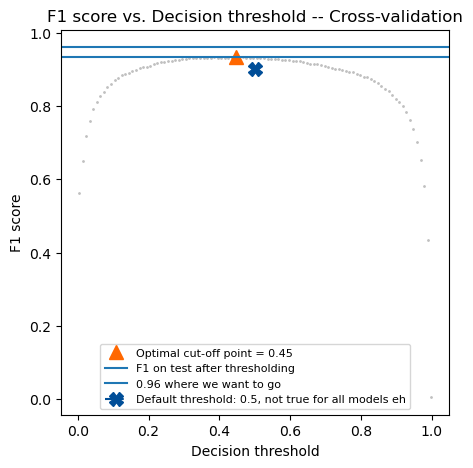

In [140]:
#https://towardsdatascience.com/tune-in-decision-threshold-optimization-with-scikit-learns-tunedthresholdclassifiercv-7de558a2cf58
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(
    threshold_modifier.cv_results_["thresholds"],
    threshold_modifier.cv_results_["scores"],
    marker="o",
    linewidth=1e-3,
    markersize=1,
    color="#c0c0c0",
)
ax.plot(
    threshold_modifier.best_threshold_,
    threshold_modifier.best_score_,
    "^",
    markersize=10,
    color="#ff6700",
    label=f"Optimal cut-off point = {threshold_modifier.best_threshold_:.2f}",
)
ax.axhline(f1_score(y_TEST_G, y_pred_t), label ="F1 on test after thresholding")

ax.axhline(0.96, label ="0.96 where we want to go")


ax.plot(
    0.5,
    0.90,
    label="Default threshold: 0.5, not true for all models eh",
    color="#004e98",
    linestyle="--",
    marker="X",
    markersize=10,
)
ax.legend(fontsize=8, loc="lower center")
ax.set_xlabel("Decision threshold", fontsize=10)
ax.set_ylabel("F1 score", fontsize=10)
ax.set_title("F1 score vs. Decision threshold -- Cross-validation", fontsize=12)

In [32]:
# tuning_voting = { 
#     # This is not working too well I feel like but whatever.
#     # The JSON will give an error which is problematic. because decision tree classifier
#     # gets returned.
#     "voting": {
#         "model": VotingClassifier([
#         ('lr', LogisticRegression()), ('svm', SVC(probability=True)), ('rf', RandomForestClassifier())
#             ]),
#         "preprocess": {
#             "standardize":True, # Needed for the SVC.
#             "pca":True
#         },
#         "fixed_params" : {
#             # Almost in the definition of a random forest.
#             "voting__weights":None
#         }
#         ,
#         "grid_search_params":{
#             # If expensive kick out the highest number of trees.
#             # 100 is default
#             #Not playing with tree depth or whatever, trees are going to go deep.
#          # Models should be calibrated already.
#             "voting__voting":["hard","soft"],
#             "pca__n_components":[10,100]
#         }
#     }
    
# }